In [1]:
import numpy as np
import pandas as pd
import gym
import copy
import random
import keras
from keras.models import Model
from keras.layers.core import Dense
from keras.engine.input_layer import Input
from keras.optimizers import Adam, RMSprop
import sklearn
import sklearn.preprocessing
from scipy.stats import norm, truncnorm
from numpy.random import seed
SEED = 1337
seed(SEED)

Using TensorFlow backend.


In [2]:
env = gym.make("MountainCarContinuous-v0")
gamma = 0.99

In [3]:
# Во избежание всякого зла будем нормализовать состояние
state_space_samples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(state_space_samples)

def scale_state(state): 
    scaled = scaler.transform([state])
    return scaled

In [4]:
class Memory:
    """Хранилище записей"""
    def __init__(self, volume):
        self.volume = volume
        self.memory = []

    def push(self, element):
        """Сохраняет элемент в циклический буфер"""
        if len(self.memory) < self.volume:
            self.memory.append(element)
        else:
            self.memory.pop(0)
            self.memory.append(element)

    def sample(self, batch_size):
        """Возвращает случайную выборку указанного размера"""
        return list(zip(*random.sample(self.memory, batch_size)))
    
    def __len__(self):
        return len(self.memory)

In [5]:
def create_model():
    """Возвращает критика и актора в виде одной сетки с двумя выходами"""
    state = Input(shape=(2,), name='state')
    x = Dense(200, activation='elu')(state)
    x = Dense(200, activation='elu')(x)
    output = Dense(1, activation='tanh', name='output')(x)
    action = Dense(1, name='action')(output)
    y = keras.layers.concatenate([state, output])
    y = Dense(40, activation='elu')(y)
    y = Dense(40, activation='elu')(y)   
    value = Dense(1, name='value')(y)
    model = Model(inputs=[state], outputs=[value, action])
    # На всякий случай зануляем лосс у актора
    optimizer = Adam(clipvalue=0.1)
    model.compile(optimizer=optimizer, loss='mse', loss_weights=[1., 0.])
    return model

In [6]:
def get_action(model, state, eps):
    """Возвращает действие + шум с std равным eps"""
    return [np.clip(norm.rvs(model.predict(state)[1][0], eps), -1, 1)]

In [7]:
def update(model, target_model, batch):
    state, action, reward, next_state, not_done = batch
    y = target_model.predict(np.array(next_state))
    y[0] = (reward + gamma * y[0].squeeze() * not_done).reshape(-1, 1)
    model.fit({'state': np.array(state)}, {'value': y[0], 'action': y[1]}, verbose=0)

In [8]:
def train():
    batch_size = 32
    n_episodes = 50
    # Границы дисперсии шума для exploration
    max_epsilon = 1.0
    min_epsilon = 0.01
    # Коэффициент обновления весов target
    tau = 0.01
    memory = Memory(10000)
    model = create_model()
    target_model = keras.models.clone_model(model)
    rewards_mean = []
    rewards_std = []
    step = 0

    for episode in range(n_episodes):        
        state = env.reset()
        done = False
        while not done:
            epsilon = max(max_epsilon - step * (max_epsilon - min_epsilon) / 100, min_epsilon)
            action = get_action(model, scale_state(state), epsilon)
            new_state, reward, done, _ = env.step(action)
            modified_reward = reward
            
            memory.push((scale_state(state)[0], action, modified_reward, scale_state(new_state)[0], not done))
            state = new_state
            step += 1
            # Тренируем model и обновляем веса target_model 
            if step > 100:
                update(model, target_model, memory.sample(batch_size))
                old_weights = np.array(target_model.get_weights()) * (1 - tau)
                new_weights = np.array(model.get_weights()) * tau
                target_model.set_weights(old_weights + new_weights)
        
        # Тестим модельку
        list_of_rewards = []
        list_of_steps = []
        for i in range(10):
            done = False
            state = env.reset()
            total_reward = 0
            steps = 0
            while not done:
                action = get_action(target_model, scale_state(state), 0)
                state, reward, done, _ = env.step(action)
                total_reward += reward
                steps += 1
            list_of_rewards.append(total_reward)
            list_of_steps.append(steps)
        state = env.reset()
        done = False
        rewards_mean.append(np.mean(list_of_rewards))
        rewards_std.append(np.std(list_of_rewards))
        print('mean: %.2f, std: %.2f, average steps: %.2f' % (np.mean(list_of_rewards), np.std(list_of_rewards), np.mean(list_of_steps)))
    return rewards_mean, rewards_std, model

In [9]:
means, stds, train = train()

mean: -91.87, std: 4.66, average steps: 999.00
mean: -98.04, std: 2.14, average steps: 999.00
mean: 30.74, std: 66.56, average steps: 516.70
mean: 57.18, std: 53.73, average steps: 344.80
mean: 55.59, std: 52.88, average steps: 359.30
mean: 84.35, std: 5.01, average steps: 168.20
mean: 50.03, std: 75.04, average steps: 305.40
mean: 67.61, std: 55.97, average steps: 231.50
mean: 87.57, std: 3.70, average steps: 129.80
mean: 87.13, std: 4.23, average steps: 132.90
mean: 67.88, std: 56.54, average steps: 224.80
mean: 63.54, std: 58.41, average steps: 267.80
mean: 70.15, std: 56.70, average steps: 202.10
mean: 89.59, std: 1.05, average steps: 106.40
mean: 89.40, std: 1.12, average steps: 109.10
mean: 89.90, std: 0.36, average steps: 103.50
mean: 90.23, std: 0.22, average steps: 99.50
mean: 90.35, std: 0.21, average steps: 97.90
mean: 90.46, std: 0.17, average steps: 96.80
mean: 90.40, std: 0.29, average steps: 97.20
mean: 90.42, std: 0.26, average steps: 97.10
mean: 90.56, std: 0.17, avera

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

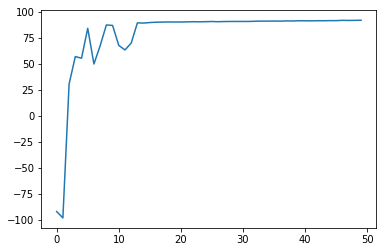

In [11]:
plt.plot(means)
plt.show()